In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import ColorMode
import random
import cv2
import os
from os import listdir

from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset", {}, "stage1_train_annotations.json", "./stage1_train")  # registet_coco_dataset

metadata = MetadataCatalog.get("my_dataset")  # to get matadata for visualization

In [2]:
def rle_encoding(x):
    
    dots = np.where(x.T.flatten()==1)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [4]:
cfg = get_cfg()
cfg.merge_from_file("./model/cascade_mask_rcnn_R_50_FPN_3x.yaml")  # use cascade_mask_rcnn_R50_FPN for trainging model config
cfg.OUTPUT_DIR = "./output_Cascade"  # output weight directroy path
cfg.MODEL.WEIGHTS = "./output_Cascade/model_0004999.pth"  #  the path for weight save 
cfg.DATASETS.TRAIN = ("my_dataset",)  # use training data
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300  
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("my_dataset")
predictor = DefaultPredictor(cfg)

WARNING [01/01 22:15:29 d2.config.compat]: Config './model/cascade_mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


Visualization

True

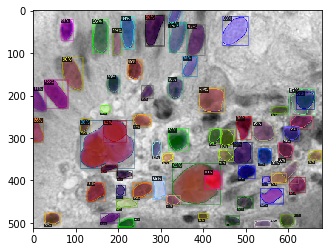

In [7]:
from detectron2.utils.visualizer import ColorMode
from itertools import groupby

im = cv2.imread('./stage1_test/472b1c5ff988dadc209faea92499bc07f305208dbda29d16262b3d543ac91c71.png')  # select image for visualizer to check our dataset weather correct
outputs = predictor(im)

v = Visualizer(im[:, :, ::-1],
               metadata=metadata,
               scale=1,
               instance_mode=ColorMode.IMAGE_BW  # remove the colors of unsegmented pixels
               )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))  
plt.imshow(v.get_image())
cv2.imwrite('demo.png',v.get_image())

Submission

In [ ]:
import pandas as pd
import os 

path = "./output_augment_flip/"  # the weight save path
fold = os.listdir(path)

inpath = "./stage2_test_final/"  # test data path
images_name = listdir(inpath)

# . use for .png name
def last_11chars(x):
    return(x[-11:])

fold = sorted(fold, key = last_11chars)   

for weight in fold:
    cfg = get_cfg()
    cfg.merge_from_file("./model/cascade_mask_rcnn_R_50_FPN_3x.yaml")  # model config file path
    cfg.OUTPUT_DIR = path
    cfg.MODEL.WEIGHTS = os.path.join(path,weight)
    cfg.DATASETS.TRAIN = ("my_dataset",)
    cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 300000    # 300 iterations seems good enough, but you can certainly train longer
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 3 classes (data, fig, hazelnut)
    cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8, 32, 64, 128, 256, 512]]
    cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.2, 0.5, 1.0, 2.0, 5.0]]
    cfg.MODEL.ROI_MASK_HEAD.POOLER_RESOLUTION = 28
    cfg.TEST.DETECTIONS_PER_IMAGE = 500
    cfg.SOLVER.WARMUP_FACTOR = 0.01
    cfg.SOLVER.WARMUP_ITERS = 10000
    cfg.INPUT.CROP.SIZE = [1.0, 1.0]
    cfg.DATASETS.TEST = ("my_dataset")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
    predictor = DefaultPredictor(cfg)

    print(weight)
    
    Img_ID = []
    EncodedPixels = []
    num = 0
    conv = lambda l: ' '.join(map(str, l))
    
    for name in images_name:
        image = cv2.imread(inpath + name)
        outputs = predictor(image)
        print(num)
        num+=1
    # print(np.asarray(outputs["instances"].to('cpu')._fields['pred_masks'][0]).shape)
        masks = postprocess_masks(np.asarray(outputs["instances"].to('cpu')._fields['pred_masks']), outputs["instances"].to('cpu')._fields['scores'].numpy(), image)

        if masks: # If any objects are detected in this image
            for i in range(len(masks)): # Loop all instances
                Img_ID.append(name.replace('.png',''))            
                EncodedPixels.append(conv(rle_encoding(masks[i])))

    df = pd.DataFrame({"ImageId" : Img_ID, "EncodedPixels" : EncodedPixels})
    df.to_csv("./output_flip_csv/R50_flip_"+weight+".csv",index=False,sep=',')

In [3]:
from skimage.measure import find_contours
from skimage.measure import label
from scipy.ndimage.morphology import binary_fill_holes
from skimage.morphology import dilation, erosion

# https://github.com/mirzaevinom/data_science_bowl_2018/blob/master/codes/predict.py
def postprocess_masks(ori_mask, ori_score, image, min_nuc_size=15):

    """Clean overlaps between bounding boxes, fill small holes, smooth boundaries"""
    # print(ori_mask[0].shape)
    height, width = image.shape[:2]
    
    score_threshold = 0.9

    # If there is no mask prediction or less than score threshold
    if len(ori_mask) == 0 or ori_score.all() < score_threshold:
        return

    keep_ind = np.where(np.sum(ori_mask, axis=(0, 1)) > min_nuc_size)[0]
    if len(keep_ind) < len(ori_mask):  # keep_ind possible to be zero zero
        # print(keep_ind.shape)  # would be like (0,) or like (1,)
        if(keep_ind.shape[0] != 0):
            # print(keep_ind.shape)
            ori_mask = ori_mask[:keep_ind.shape[0]]  # shape[0]:to int
            ori_scrore = ori_score[:keep_ind.shape[0]]
        else:
            ori_mask = []
            ori_score = []
        
    # can skip sort phase
    # sort_ind = np.argsort(ori_score)[::-1]
    # print(sort_ind)
    # ori_mask = ori_mask[..., sort_ind]

    overlap = np.zeros([height, width])

    masks = []
    # Removes overlaps from masks with lower score
    for i in range(len(ori_mask)):
        # Fill holes inside the mask
        mask = binary_fill_holes(ori_mask[i]).astype(np.uint8)
        # Smoothen edges using dilation and erosion
        mask = erosion(dilation(mask))
        # Delete overlaps
        overlap += mask
        mask[overlap > 1] = 0
        out_label = label(mask)
        # Remove all the pieces if there are more than one pieces
        if out_label.max() > 1:
            mask[()] = 0

        masks.append(mask)

    return masks